In [1]:
import os
import pickle
import numpy as np
import xml.etree.ElementTree as ET
import random
import svgwrite
from IPython.display import SVG, display
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from utils import *
from sample import *

In [4]:
class FakeArgParse():
    def __init__(self):
        pass
args = FakeArgParse()

args.train = False

args.rnn_size = 100
args.tsteps = 250
args.nmixtures = 6

args.kmixtures = 2
args.alphabet = ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
args.tsteps_per_ascii = 25

args.batch_size = 1
args.nepochs = 250
args.dropout = 0.8
args.nbatches = 500

args.grad_clip = 10
args.learning_rate = 1e-4
args.lr_decay = 0.95

args.data_scale = 20
args.data_dir = './data'
args.log_dir = './output/'
args.save_path = './output/d4/model'
args.save_every = 50

args.text = ''
args.bias = 0
args.style = -1
args.optimizer = 'rmsprop'
args.decay = 0.95
args.momentum = 0.9

In [5]:
class Model():
    def __init__(self, args):
        tf.reset_default_graph()

        self.rnn_size = args.rnn_size
        self.train = args.train
        self.nmixtures = args.nmixtures
        self.kmixtures = args.kmixtures
        self.batch_size = args.batch_size if self.train else 1 # training/sampling specific
        self.tsteps = args.tsteps if self.train else 1 # training/sampling specific
        self.alphabet = args.alphabet
        # training params
        self.dropout = args.dropout
        self.grad_clip = args.grad_clip
        # misc
        self.tsteps_per_ascii = args.tsteps_per_ascii
        self.data_dir = args.data_dir

        self.graves_initializer = tf.truncated_normal_initializer(mean=0., stddev=.075, seed=None, dtype=tf.float32)
        self.window_b_initializer = tf.truncated_normal_initializer(mean=-3.0, stddev=.25, seed=None, dtype=tf.float32) # hacky initialization

        self.char_vec_len = len(self.alphabet) + 1 #plus one for <UNK> token
        self.ascii_steps = args.tsteps/args.tsteps_per_ascii


        # ----- build the basic recurrent network architecture
        cell_func = tf.contrib.rnn.LSTMCell # could be GRUCell or RNNCell
        self.cell0 = cell_func(args.rnn_size, state_is_tuple=True, initializer=self.graves_initializer)
        self.cell1 = cell_func(args.rnn_size, state_is_tuple=True, initializer=self.graves_initializer)
        self.cell2 = cell_func(args.rnn_size, state_is_tuple=True, initializer=self.graves_initializer)

        if (self.train and self.dropout < 1): # training mode
            self.cell0 = tf.contrib.rnn.DropoutWrapper(self.cell0, output_keep_prob = self.dropout)
            self.cell1 = tf.contrib.rnn.DropoutWrapper(self.cell1, output_keep_prob = self.dropout)
            self.cell2 = tf.contrib.rnn.DropoutWrapper(self.cell2, output_keep_prob = self.dropout)

        self.input_data = tf.placeholder(dtype=tf.float32, shape=[None, self.tsteps, 3])
        self.target_data = tf.placeholder(dtype=tf.float32, shape=[None, self.tsteps, 3])
        self.istate_cell0 = self.cell0.zero_state(batch_size=self.batch_size, dtype=tf.float32)
        self.istate_cell1 = self.cell1.zero_state(batch_size=self.batch_size, dtype=tf.float32)
        self.istate_cell2 = self.cell2.zero_state(batch_size=self.batch_size, dtype=tf.float32)

        #slice the input volume into separate vols for each tstep
        inputs = [tf.squeeze(input_, [1]) for input_ in tf.split(self.input_data, self.tsteps, 1)]
        #build cell0 computational graph
        outs_cell0, self.fstate_cell0 = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, self.istate_cell0, self.cell0, loop_function=None, scope='cell0')


        # ----- build the gaussian character window
        def get_window(alpha, beta, kappa, c):
            # phi -> [? x 1 x ascii_steps] and is a tf matrix
            # c -> [? x ascii_steps x alphabet] and is a tf matrix
            ascii_steps = c.get_shape()[1].value #number of items in sequence
            phi = get_phi(ascii_steps, alpha, beta, kappa)
            window = tf.matmul(phi,c)
            window = tf.squeeze(window, [1]) # window ~ [?,alphabet]
            return window, phi

        #get phi for all t,u (returns a [1 x tsteps] matrix) that defines the window
        def get_phi(ascii_steps, alpha, beta, kappa):
            # alpha, beta, kappa -> [?,kmixtures,1] and each is a tf variable
            u = np.linspace(0,ascii_steps-1,ascii_steps) # weight all the U items in the sequence
            kappa_term = tf.square( tf.subtract(kappa,u))
            exp_term = tf.multiply(-beta,kappa_term)
            phi_k = tf.multiply(alpha, tf.exp(exp_term))
            phi = tf.reduce_sum(phi_k,1, keep_dims=True)
            return phi # phi ~ [?,1,ascii_steps]

        def get_window_params(i, out_cell0, kmixtures, prev_kappa, reuse=True):
            hidden = out_cell0.get_shape()[1]
            n_out = 3*kmixtures
            with tf.variable_scope('window',reuse=reuse):
                window_w = tf.get_variable("window_w", [hidden, n_out], initializer=self.graves_initializer)
                window_b = tf.get_variable("window_b", [n_out], initializer=self.window_b_initializer)
            abk_hats = tf.nn.xw_plus_b(out_cell0, window_w, window_b) # abk_hats ~ [?,n_out]
            abk = tf.exp(tf.reshape(abk_hats, [-1, 3*kmixtures,1])) # abk_hats ~ [?,n_out] = "alpha, beta, kappa hats"

            alpha, beta, kappa = tf.split(abk, 3, 1) # alpha_hat, etc ~ [?,kmixtures]
            kappa = kappa + prev_kappa
            return alpha, beta, kappa # each ~ [?,kmixtures,1]

        self.init_kappa = tf.placeholder(dtype=tf.float32, shape=[None, self.kmixtures, 1])
        self.char_seq = tf.placeholder(dtype=tf.float32, shape=[None, self.ascii_steps, self.char_vec_len])
        prev_kappa = self.init_kappa

        reuse = False
        #add gaussian window result
        for i in range(len(outs_cell0)):
            [alpha, beta, new_kappa] = get_window_params(i, outs_cell0[i], self.kmixtures, prev_kappa, reuse=reuse)
            window, phi = get_window(alpha, beta, new_kappa, self.char_seq)
            outs_cell0[i] = tf.concat((outs_cell0[i],window), 1) #concat outputs
            outs_cell0[i] = tf.concat((outs_cell0[i],inputs[i]), 1) #concat input data
            prev_kappa = new_kappa
            reuse = True

        #save some attention mechanism params (useful for sampling/debugging later)
        self.window = window
        self.phi = phi
        self.new_kappa = new_kappa
        self.alpha = alpha

        # ----- finish building LSTMs 2 and 3
        outs_cell1, self.fstate_cell1 = tf.contrib.legacy_seq2seq.rnn_decoder(outs_cell0, self.istate_cell1, self.cell1, loop_function=None, scope='cell1')

        outs_cell2, self.fstate_cell2 = tf.contrib.legacy_seq2seq.rnn_decoder(outs_cell1, self.istate_cell2, self.cell2, loop_function=None, scope='cell2')

        n_out = 1 + self.nmixtures * 6 # params = end_of_stroke + 6 parameters per Gaussian
        with tf.variable_scope('mdn_dense'):
            mdn_w = tf.get_variable("output_w", [self.rnn_size, n_out], initializer=self.graves_initializer)
            mdn_b = tf.get_variable("output_b", [n_out], initializer=self.graves_initializer)

        out_cell2 = tf.reshape(tf.concat(outs_cell2, 1), [-1, args.rnn_size]) #concat outputs for efficiency
        output = tf.nn.xw_plus_b(out_cell2, mdn_w, mdn_b) #data flows through dense nn

        # ----- build mixture density cap on top of second recurrent cell
        def gaussian2d(x1, x2, mu1, mu2, s1, s2, rho):
            # define gaussian mdn (eq 24, 25 from http://arxiv.org/abs/1308.0850)
            x_mu1 = tf.subtract(x1, mu1)
            x_mu2 = tf.subtract(x2, mu2)
            Z = tf.square(tf.div(x_mu1, s1)) + \
                tf.square(tf.div(x_mu2, s2)) - \
                2*tf.div(tf.multiply(rho, tf.multiply(x_mu1, x_mu2)), tf.multiply(s1, s2))
            rho_square_term = 1-tf.square(rho)
            power_e = tf.exp(tf.div(-Z,2*rho_square_term))
            regularize_term = 2*np.pi*tf.multiply(tf.multiply(s1, s2), tf.sqrt(rho_square_term))
            gaussian = tf.div(power_e, regularize_term)
            return gaussian

        def get_loss(pi, x1_data, x2_data, eos_data, mu1, mu2, sigma1, sigma2, rho, eos):
            # define loss function (eq 26 of http://arxiv.org/abs/1308.0850)
            gaussian = gaussian2d(x1_data, x2_data, mu1, mu2, sigma1, sigma2, rho)
            term1 = tf.multiply(gaussian, pi)
            term1 = tf.reduce_sum(term1, 1, keep_dims=True) #do inner summation
            term1 = -tf.log(tf.maximum(term1, 1e-20)) # some errors are zero -> numerical errors.

            term2 = tf.multiply(eos, eos_data) + tf.multiply(1-eos, 1-eos_data) #modified Bernoulli -> eos probability
            term2 = -tf.log(term2) #negative log error gives loss

            return tf.reduce_sum(term1 + term2) #do outer summation

        # now transform dense NN outputs into params for MDN
        def get_mdn_coef(Z):
            # returns the tf slices containing mdn dist params (eq 18...23 of http://arxiv.org/abs/1308.0850)
            eos_hat = Z[:, 0:1] #end of sentence tokens
            pi_hat, mu1_hat, mu2_hat, sigma1_hat, sigma2_hat, rho_hat = tf.split(Z[:, 1:], 6, 1)
            self.pi_hat, self.sigma1_hat, self.sigma2_hat = \
                pi_hat, sigma1_hat, sigma2_hat # these are useful for bias method during sampling

            eos = tf.sigmoid(-1*eos_hat) # technically we gained a negative sign
            pi = tf.nn.softmax(pi_hat) # softmax z_pi:
            mu1 = mu1_hat; mu2 = mu2_hat # leave mu1, mu2 as they are
            sigma1 = tf.exp(sigma1_hat); sigma2 = tf.exp(sigma2_hat) # exp for sigmas
            rho = tf.tanh(rho_hat) # tanh for rho (squish between -1 and 1)rrr
            print 'mu1', mu1
            print 'eos', eos

            return [eos, pi, mu1, mu2, sigma1, sigma2, rho]

        # reshape target data (as we did the input data)
        flat_target_data = tf.reshape(self.target_data,[-1, 3])
        [x1_data, x2_data, eos_data] = tf.split(flat_target_data, 3, 1) #we might as well split these now

        [self.eos, self.pi, self.mu1, self.mu2, self.sigma1, self.sigma2, self.rho] = get_mdn_coef(output)

        print 'x1_data', x1_data

        loss = get_loss(self.pi, x1_data, x2_data, eos_data, self.mu1, self.mu2, self.sigma1, self.sigma2, self.rho, self.eos)
        self.cost = loss / (self.batch_size * self.tsteps)

        self.learning_rate = tf.Variable(0.0, trainable=False)
        self.decay = tf.Variable(0.0, trainable=False)
        self.momentum = tf.Variable(0.0, trainable=False)

        if args.optimizer == 'adam':
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        elif args.optimizer == 'rmsprop':
            self.optimizer = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate, decay=self.decay, momentum=self.momentum)
        else:
            raise ValueError("Optimizer type not recognized")

        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars), self.grad_clip)

        self.train_op = self.optimizer.apply_gradients(zip(grads, tvars))

        # ----- some TensorFlow I/O
        self.sess = tf.InteractiveSession()
        self.saver = tf.train.Saver(tf.global_variables())
        self.sess.run(tf.global_variables_initializer())

    def try_load_model(self, save_path):
        load_was_success = True # yes, I'm being optimistic
        global_step = 0
        try:
            save_dir = '/'.join(save_path.split('/')[:-1])
            ckpt = tf.train.get_checkpoint_state(save_dir)
            load_path = ckpt.model_checkpoint_path
            self.saver.restore(self.sess, load_path)
        except:
            print ("no saved model to load. starting new session")
            load_was_success = False
        else:
            print ("loaded model: {}".format(load_path))
            self.saver = tf.train.Saver(tf.global_variables())
            #global_step = int(load_path.split('-')[-1])
        return load_was_success, global_step

In [4]:
def train_model(args):
    logger = Logger(args) # make logging utility
    logger.write("\nTRAINING MODE...")
    logger.write("{}\n".format(args))
    logger.write("loading data...")
    data_loader = DataLoader(args, logger=logger)

    logger.write("building model...")
    model = Model(args)

    v_x, v_y, v_s, v_c = data_loader.validation_data()
    valid_inputs = {model.input_data: v_x, model.target_data: v_y, model.char_seq: v_c}

    logger.write("training...")
    model.sess.run(tf.assign(model.decay, args.decay ))
    model.sess.run(tf.assign(model.momentum, args.momentum ))
    for e in range(args.nepochs):
        model.sess.run(tf.assign(model.learning_rate, args.learning_rate * (args.lr_decay ** e)))
        logger.write("learning rate: {}".format(model.learning_rate.eval()))

        c0, c1, c2 = model.istate_cell0.c.eval(), model.istate_cell1.c.eval(), model.istate_cell2.c.eval()
        h0, h1, h2 = model.istate_cell0.h.eval(), model.istate_cell1.h.eval(), model.istate_cell2.h.eval()
        kappa = np.zeros((args.batch_size, args.kmixtures, 1))

        for b in range(args.nbatches):

            i = e * args.nbatches + b

            if i % args.save_every == 0 and (i > 0):
                model.saver.save(model.sess, args.save_path) ; logger.write('SAVED MODEL')
                with open(args.log_dir + '/checkpoint', "w") as raw:
                    raw.write('model_checkpoint_path: "model"\nall_model_checkpoint_paths: "model"')

            start = time.time()
            x, y, s, c = data_loader.next_batch()

            feed = {model.input_data: x, model.target_data: y, model.char_seq: c, model.init_kappa: kappa, \
              model.istate_cell0.c: c0, model.istate_cell1.c: c1, model.istate_cell2.c: c2, \
              model.istate_cell0.h: h0, model.istate_cell1.h: h1, model.istate_cell2.h: h2}

            [train_loss, _] = model.sess.run([model.cost, model.train_op], feed)

            end = time.time()
            if i % 10 is 0: logger.write("{}/{}, loss = {:.3f}, time = {:.3f}" \
                .format(i, args.nepochs * args.nbatches, train_loss, end - start) )


In [ ]:
train_model(args)

In [6]:
#load model
logger = Logger(args)
logger.write("\nSAMPLING MODE...")
logger.write("loading data...")
logger.write("building model...")
model = Model(args)


SAMPLING MODE...
loading data...
building model...
mu1 Tensor("split_3:1", shape=(1, 6), dtype=float32)
eos Tensor("Sigmoid:0", shape=(1, 1), dtype=float32)
x1_data Tensor("split_2:0", shape=(?, 1), dtype=float32)


In [7]:
logger.write("attempt to load saved model...")
load_was_success, global_step = model.try_load_model(args.save_path)

attempt to load saved model...
INFO:tensorflow:Restoring parameters from ./output/d4/model


INFO:tensorflow:Restoring parameters from ./output/d4/model


no saved model to load. starting new session


In [37]:
def sample_model(args, model, logger=None):
    if args.text == '':
        strings = ['Gaurav Gupta'] # test strings
    else:
        strings = [args.text]

    if True:
        for s in strings:
            strokes, phis, windows, kappas = sample(s, model, args)

            w_save_path = '{}figures/iter-{}-w-{}'.format(args.log_dir, global_step, s[:10].replace(' ', '_'))
            g_save_path = '{}figures/iter-{}-g-{}'.format(args.log_dir, global_step, s[:10].replace(' ', '_'))
            l_save_path = '{}figures/iter-{}-l-{}'.format(args.log_dir, global_step, s[:10].replace(' ', '_'))

            window_plots(phis, windows, save_path=w_save_path)
            gauss_plot(strokes, 'Heatmap for "{}"'.format(s), figsize = (2*len(s),4), save_path=g_save_path)
            line_plot(strokes, 'Line plot for "{}"'.format(s), figsize = (len(s),2), save_path=l_save_path)

            # make sure that kappas are reasonable
            logger.write( "kappas: \n{}".format(str(kappas[min(kappas.shape[0]-1, args.tsteps_per_ascii),:])) )
    else:
        logger.write("load failed, sampling canceled")

kappas: 
[ 1.91530049]


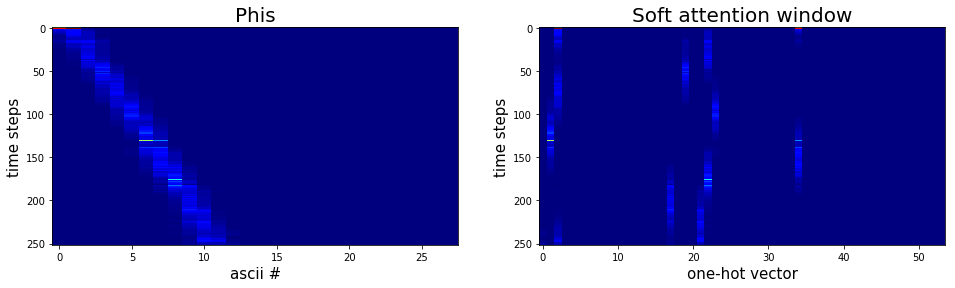

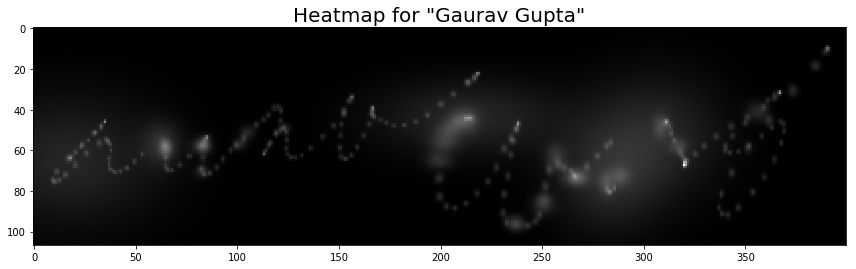

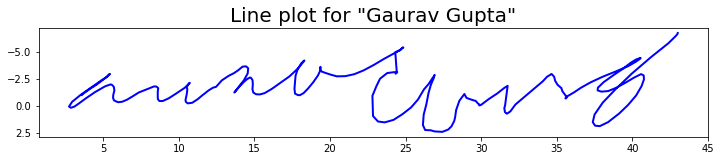

In [40]:
sample_model(args, model, logger)